In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
from transformers import AutoModel, AutoModelForImageClassification, AutoImageProcessor, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, get_cosine_schedule_with_warmup
import torchaudio

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

import random
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/andy/anaconda3/envs/birdclef2025/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [ ]:
class BirdTrainDatasetPrecomputed(Dataset):
  def __init__(self, data_df, data_path = 'data/precomputed_spectrograms/spectrograms', use_cutmix = True):
    self.df = data_df
    self.path = data_path
    self.cutmix = use_cutmix

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      path = self.df.iloc[idx]['file_path']
      label = self.df.iloc[idx]['label']
      spec = torch.load(path)

      # formatted for trainer
      return {
          "pixel_values": spec,
          "labels": torch.tensor(label, dtype=torch.long),
          "file_name": path,
      }
  
def get_datasets(df):
    """
    divides by original files instead of snippet files to avoid data leakage
    """

    # make new dataframe with just index and labels. remove all duplcates
    df_copy = df.copy()                 # Duplicate the DataFrame
    df_copy = df_copy.drop('file_path', axis=1)  # Drop the 'file_path' column
    df_copy = df_copy.drop_duplicates()          # Remove duplicate rows

    # Split data into train and validation sets
    train_df_idx, val_df_idx = train_test_split(
      df_copy, 
      test_size=0.2, 
      random_state=42, 
      stratify=df_copy['label']
    )

    # create dfs containing segmented audio from partitioned files
    train_df = df[df['file_num'].isin(train_df_idx['file_num'])]
    val_df = df[df['file_num'].isin(val_df_idx['file_num'])]

    train_ds = BirdTrainDatasetPrecomputed(train_df)
    val_ds = BirdTrainDatasetPrecomputed(val_df)
    return train_ds, val_ds

df = pd.read_csv('/home/andy/Desktop/BirdClef/customSED/data/precomputed_spectrograms/labels.csv')
ds_train, ds_val = get_datasets(df)
print("train_loader", len(ds_train))
print("val_loader", len(ds_val))
print("num_classes", df['label'].max()+1)

train_loader 92618
val_loader 22739
num_classes 206


Filepath: data/precomputed_spectrograms/spectrograms/7836_0.pt
Target: 97
Shape of mel spectrogram: torch.Size([3, 128, 641])


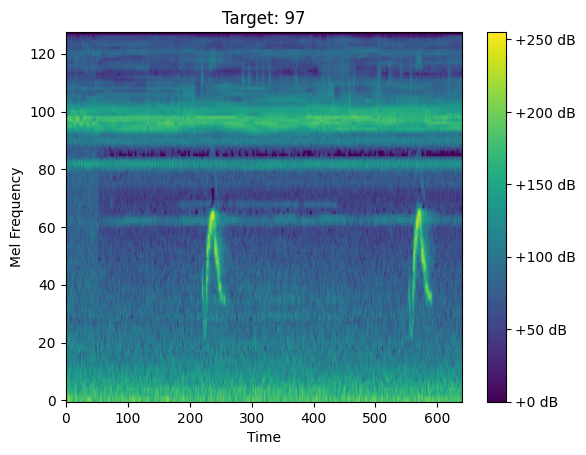

In [3]:
# print a sample spec
res = ds_train[random.randint(0, len(ds_train)-1)]
spec = res['pixel_values']
target = res['labels']

print(f"Filepath: {res['file_name']}")
print(f"Target: {target}")
print(f"Shape of mel spectrogram: {spec.shape}")

# Display the mel spectrogram
plt.imshow(spec[0], aspect='auto', origin='lower')
plt.title(f"Target: {target}")
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()

In [4]:
# print train and val loader stats
train_df = ds_train.df
val_df = ds_val.df

def print_label_stats(df, name="Dataset"):
    label_counts = df['label'].value_counts()
    max_count = label_counts.max()
    min_count = label_counts.min()
    mean_count = label_counts.mean()
    std_count = label_counts.std()

    print(f"{name} label statistics:")
    print(f"  Max:  {max_count}")
    print(f"  Min:  {min_count}")
    print(f"  Mean: {mean_count:.2f}")
    print(f"  Std:  {std_count:.2f}")
    print("")

# Print stats for training and validation datasets
print_label_stats(train_df, "Training")
print_label_stats(val_df, "Validation")

Training label statistics:
  Max:  2850
  Min:  2
  Mean: 449.60
  Std:  564.26

Validation label statistics:
  Max:  912
  Min:  1
  Mean: 119.05
  Std:  146.30



In [5]:
# Define metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate F1 score (weighted for class imbalance)
    f1 = f1_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [6]:
# Effnet finetune setup
LR = 1e-5
NUM_EPOCHS = 30
BATCH_SIZE = 32
MODEL_NAME = "google/efficientnet-b2"
NUM_CLASSES = 206
DROPOUT_RATE = .3

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_CLASSES  # Number of output classes
config.hidden_dropout_prob = DROPOUT_RATE  # Dropout for dense layers
config.attention_probs_dropout_prob = DROPOUT_RATE  # Only applicable if the model has attention layers (EfficientNet doesn't)

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_effnet_pc_random",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    learning_rate=LR,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if available
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    remove_unused_columns=False,
    warmup_steps=500,
    lr_scheduler_type="linear",
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1408]) in the checkpoint and torch.Size([206, 1408]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([206]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Create and run trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
1000,4.913200,4.997134,0.078895,0.057019
2000,4.180800,4.196555,0.214477,0.147729
3000,3.517900,3.496958,0.301289,0.214969
4000,3.118300,3.244155,0.345926,0.271426
5000,2.884500,2.918005,0.406130,0.333198
6000,2.641500,2.691051,0.437178,0.371453
7000,2.504700,2.563636,0.461498,0.410131
8000,2.375200,2.412675,0.494877,0.443817
9000,2.225800,2.368719,0.506838,0.459705
10000,2.169800,2.252433,0.521703,0.485639


TrainOutput(global_step=40000, training_loss=1.8687755365371703, metrics={'train_runtime': 4458.7414, 'train_samples_per_second': 623.167, 'train_steps_per_second': 19.479, 'total_flos': 1.5103167334293086e+19, 'train_loss': 1.8687755365371703, 'epoch': 13.81692573402418})